# Analysis plots

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import importlib
import lib
importlib.reload(lib)
matplotlib.rcParams.update({'font.size': 20})

In [25]:
# intervals = [5_000, 10_000, 100_000, 1_000_000]
intervals = [5_000, 10_000, 100_000, 1_000_000][::-1]
throughput = [8, 80, 800, 1600]
methods = [("XDP Poll", "data/xdp/poll_"), ("AF_XDP", "./data/xdp/xsk_"), ("RDMA UD", "./data/rdma/ud_"), ("UDP Socket", "./data/udp/")]
value_col = np.array([])
method_col = np.array([])
interval_col = np.array([])
for i,interval in enumerate(intervals):
    for name, path in methods:
        settings = lib.Settings(1e6, interval, isol="no", kernel="6.6.19_usi")
        # Assuming the files are already stored locally
        lat = lib.compute_latencies(lib.parse_timestamps(f"{path}{settings}.dat"))[1000:,1]/1000
        value_col = np.concatenate([value_col, lat])
        method_col = np.concatenate([method_col, np.full(lat.shape, name)])
        interval_col = np.concatenate([interval_col, np.full(lat.shape, throughput[i])])
df = pd.DataFrame({"Latency": value_col, "Method": method_col, "Interval": interval_col})

In [14]:
np.save("afxdp_800_latency.npy", df.loc[(df["Method"] == "AF_XDP") & (df["Interval"] == 800)]["Latency"].to_numpy())

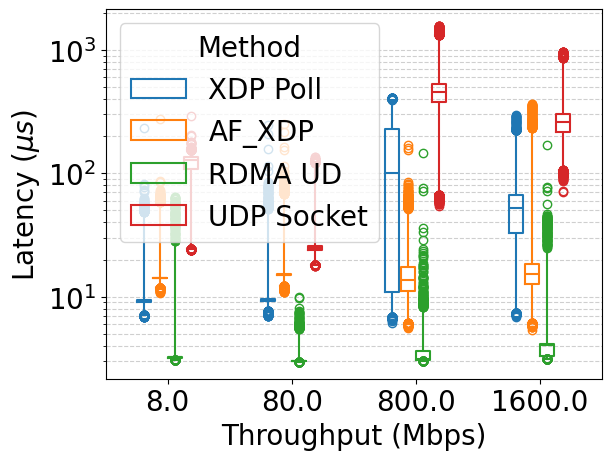

In [38]:
plt.close()
fig,ax = plt.subplots(1)
ax = sns.boxplot(x="Interval", y="Latency", hue="Method", data=df, whis=(0.01, 99.99), log_scale=True, fill=False, width=.5, gap=.1, ax=ax)

ax.set_ylabel(r"Latency ($\mu s$)")
ax.set_xlabel("Throughput (Mbps)")
ax.grid(linestyle="--", which="both", axis="y", alpha=0.6)


In [41]:
ax.legend(loc="upper left", ncols=4)
fig.tight_layout()
fig.set_size_inches(18, 6, forward=True)

In [42]:
fig.savefig("./latency_interval_boxplot.png",dpi=400)

In [22]:
# intervals = [5_000, 10_000, 100_000, 1_000_000]
interval = 1_000_000
sizes = [128, 1024]
methods = [("XDP Poll", "./data/xdp/poll_"), ("AF_XDP", "./data/xdp/xsk_"), ("RDMA UD", "./data/rdma/ud_"), ("UDP Socket", "./data/noby/")]
value_col = np.array([])
method_col = np.array([])
size_col = np.array([])
for size in sizes:
    for name, path in methods:
        opts = {"isol": "no", "kernel": "6.6.19", "": "usi"}
        if size != 1024:
            opts["size"] = "128B"
        settings = lib.Settings(1e6, interval, **opts)
        lat = lib.compute_latencies(lib.parse_timestamps(f"{path}{settings}.dat"))[1000:,1]/1000
        value_col = np.concatenate([value_col, lat])
        method_col = np.concatenate([method_col, np.full(lat.shape, name)])
        size_col = np.concatenate([size_col, np.full(lat.shape, "128" if size == 128 else "1024")])
size_df = pd.DataFrame({"Latency": value_col, "Method": method_col, "Size": size_col})

FileNotFoundError: [Errno 2] No such file or directory: './data/xdp/poll_1M-1ms-isol_no-kernel_6.6.19-_usi-size_128B.dat'

<function histogram at 0x7fac64478eb0>

In [49]:
plt.close()
ax = sns.boxplot(x="Size", y="Latency", hue="Method", data=size_df, whis=(0.01, 99.99), log_scale=True, fill=False, width=.5, gap=.1)
# for i in range(0, len(intervals)):
#     ax.axvline(i+0.5, dashes=(2,2))
ax.set_ylabel(r"Latency ($\mu s$)")
ax.set_xlabel("Packet size (Bytes)")
ax.grid(linestyle="--", axis="y")
ax.legend(loc="upper center")
fig = ax.get_figure()
fig.tight_layout()


In [10]:
fig.tight_layout()
fig.set_size_inches(13, 8, forward=True)

In [11]:
fig.savefig("./fig/latency_size_boxplot.png")

In [46]:
interval = 100_000
# size = 1024
isolation = [(False, False), (False, True), (True, True)]
methods = [("XDP Poll", "./data/xdp/poll_"), ("AF_XDP", "./data/xdp/xsk_"), ("RDMA UD", "./data/rdma/ud_"), ("UDP Socket", "./data/udp/")]
value_col = np.array([])
method_col = np.array([])
isol_col = np.array([])
for isol, stress in isolation:
    for name,path in methods:
        opts = {}
        if isol:
            opts["isol"] = "yes"
        else:
            opts["isol"] = "no"
        opts["kernel"] = "6.6.19"
        # opts["suffix"] = "usi"
        if stress and not isol:
            opts["stress"] = "80"

        settings = lib.Settings(1e6, interval, **opts)
        lat = lib.compute_latencies(lib.parse_timestamps(f"{path}{settings}_usi.dat"))[1000:,1]/1000
        # print(name, isol, stress, lat.mean())
        value_col = np.concatenate([value_col, lat])
        method_col = np.concatenate([method_col, np.full(lat.shape, name)])
        isolname = "Tuned" if isol else "Default"
        if stress:
            isolname += " & Stress"
        isol_col = np.concatenate([isol_col, np.full(lat.shape, isolname)])
isol_df = pd.DataFrame({"Latency": value_col, "Method": method_col, "Size": isol_col})

In [47]:
plt.close('all')

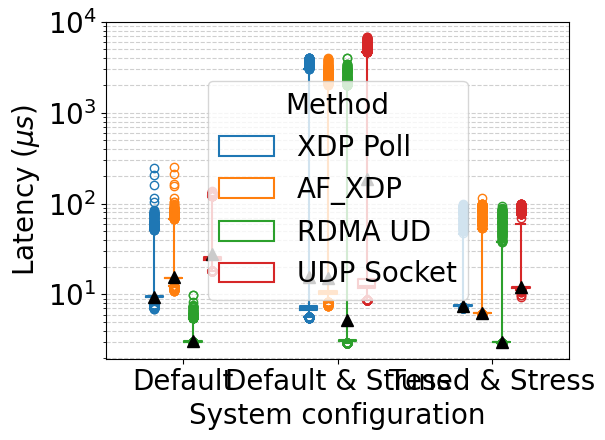

In [61]:
plt.close()
ax = sns.boxplot(x="Size", y="Latency", hue="Method", data=isol_df, whis=(0.01, 99.99), log_scale=False, fill=False, width=.5, gap=.1, showmeans=True, meanprops=dict(markeredgecolor='black',
                      markerfacecolor='black', markersize=9))
# for i in range(0, len(intervals)):
#     ax.axvline(i+0.5, dashes=(2,2))
ax.set_ylabel(r"Latency ($\mu s$)")
ax.set_xlabel("System configuration")
ax.grid(linestyle="--", axis="y", which="both", alpha=0.6)
ax.set_yscale("log")
fig = ax.get_figure()
fig.tight_layout()

In [62]:
average_icon = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                          markersize=8, label='Average')
handles, labels = ax.get_legend_handles_labels()
handles.append(average_icon)
labels.append("Average")
ax.legend(handles=handles, labels=labels,ncols=1)

In [65]:
fig.tight_layout()
ax.set_yscale("log")
fig.set_size_inches(12, 8, forward=True)

In [66]:
fig.savefig("./isolation_boxplot.png")